Found 174 images belonging to 4 classes.
Found 42 images belonging to 4 classes.
Class weights: {0: 1.0357142857142858, 1: 0.90625, 2: 1.0357142857142858, 3: 1.0357142857142858}


d:\body shape detection\benv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4368 - loss: 1.3857 - val_accuracy: 0.3095 - val_loss: 1.5985
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 848ms/step - accuracy: 0.6149 - loss: 0.9056 - val_accuracy: 0.3571 - val_loss: 1.4127
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 828ms/step - accuracy: 0.6782 - loss: 0.7415 - val_accuracy: 0.4048 - val_loss: 1.6161
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 795ms/step - accuracy: 0.7759 - loss: 0.6618 - val_accuracy: 0.3810 - val_loss: 1.6051
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 804ms/step - accuracy: 0.7931 - loss: 0.5348 - val_accuracy: 0.4048 - val_loss: 1.7237
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step - accuracy: 0.7759 - loss: 0.5160 - val_accuracy: 0.4286 - val_loss: 1.7382
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 797ms/step - accuracy: 0.9080 - loss: 0.3644 - val_accuracy: 0.3810 - val_loss: 1.7997
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 816ms/step - accuracy: 0.8563 - loss: 0.4241 - val_accuracy: 0.35

Model saved as 'body_shape_model_simple.h5'
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 938ms/step

Validation Accuracy: 52.38%

Classification Report:
                  precision    recall  f1-score   support

           Apple       0.71      0.50      0.59        10
       Hourglass       0.67      0.17      0.27        12
InvertedTriangle       0.50      0.60      0.55        10
       Rectangle       0.45      0.90      0.60        10

        accuracy                           0.52        42
       macro avg       0.58      0.54      0.50        42
    weighted avg       0.59      0.52      0.49        42


Confusion Matrix:
 [[5 0 2 3]
 [1 2 3 6]
 [1 1 6 2]
 [0 0 1 9]]

Bias Checking per Class (Predicted vs True counts):
Apple: True = 10, Predicted = 7
Hourglass: True = 12, Predicted = 3
InvertedTriangle: True = 10, Predicted = 12
Rectangle: True = 10, Predicted = 20


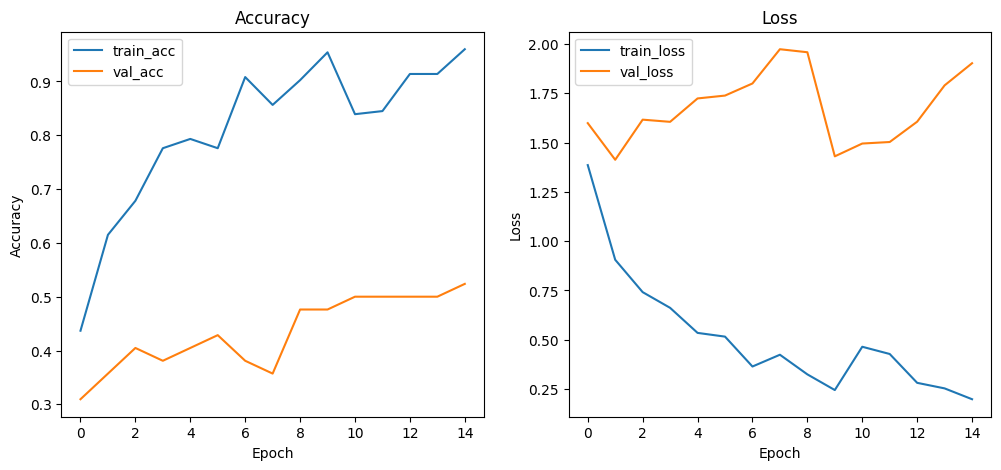

In [2]:
# %%
# ----------------------------
# Imports
# ----------------------------
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# ----------------------------
# Parameters
# ----------------------------
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 4  # Apple, Rectangle, Hourglass, InvertedTriangle
DATA_DIR = "segmented_dataset"  # images organized in class subfolders
CLASS_LABELS = ['Apple','Hourglass','InvertedTriangle','Rectangle']

# ----------------------------
# Data Generators with Advanced Augmentation
# ----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ----------------------------
# Compute Class Weights to Reduce Bias
# ----------------------------
classes = np.unique(train_generator.classes)
class_weights_array = compute_class_weight('balanced', classes=classes, y=train_generator.classes)
class_weights = dict(zip(classes, class_weights_array))
print("Class weights:", class_weights)

# ----------------------------
# Build Model (MobileNetV2 backbone)
# ----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# ----------------------------
# Freeze backbone initially
# ----------------------------
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# Train model with class weights
# ----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights
)

# ----------------------------
# Fine-tune: Unfreeze last 20 layers of backbone
# ----------------------------
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights
)

# ----------------------------
# Save model
# ----------------------------
model.save("body_shape_model_simple.h5")
print("Model saved as 'body_shape_model_simple.h5'")

# ----------------------------
# Evaluate on validation set
# ----------------------------
val_generator.reset()
val_preds = model.predict(val_generator)
val_pred_labels = np.argmax(val_preds, axis=1)
val_true_labels = val_generator.classes

val_accuracy = np.mean(val_pred_labels == val_true_labels)
print("\nValidation Accuracy: {:.2f}%".format(100*val_accuracy))

# Classification report
print("\nClassification Report:")
print(classification_report(val_true_labels, val_pred_labels, target_names=CLASS_LABELS))

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
print("\nConfusion Matrix:\n", cm)

# Bias checking per class
print("\nBias Checking per Class (Predicted vs True counts):")
for i, label in enumerate(CLASS_LABELS):
    true_count = np.sum(val_true_labels == i)
    pred_count = np.sum(val_pred_labels == i)
    print(f"{label}: True = {true_count}, Predicted = {pred_count}")

# ----------------------------
# Plot training curves
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_finetune.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
